In [1]:
import os
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import torchvision
import PIL
import matplotlib.pyplot as plt
import numpy as np



In [2]:
def conv3x3(in_channels, out_channels, **kwargs):
    # The convolutional layers (for feature extraction) use standard layers from
    # `torch.nn`, since they do not require adaptation.
    # See `examples/maml/model.py` for comparison.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [3]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        # Only the last (linear) layer is used for adaptation in ANIL
        self.classifier = torch.nn.Linear(hidden_size, out_features)

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        # print(features.shape)
        features = torch.mean(features.view(features.size(0), features.size(1), - 1), dim = -1)
        # print(features.shape)
        
        logits = self.classifier(features)
        return logits


In [4]:
model = ConvolutionalNeuralNetwork(1, 13)

In [5]:
a = torch.randn(10,1,64,64)

In [6]:
class ChessDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_path, transform_style=None):
        'Initialization'
        self.data_path = data_path
        self.labels = []
        self.image_list = []
        
        self.load_image_list()
        self.transform_style = transform_style
        
    def load_image_list(self):
        for i, image_folder in enumerate(os.listdir(self.data_path)):
            image_folder_path = os.path.join(self.data_path, image_folder)
            print(i,image_folder)
            for j, image in enumerate(os.listdir(image_folder_path)):
                if j > 20:
                    break
                image_path = os.path.join(image_folder_path, image)
                self.image_list.append(image_path)
                self.labels.append(i)
                

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        single_image_path = self.image_list[index]
        # Open image
        X = PIL.Image.open(single_image_path).convert("L")
        #X = PIL.ImageOps.invert(img)
        if self.transform_style:
            X = self.transform_style(X)
        
        y = self.labels[index]

        return X, y

In [7]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [8]:
my_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    MyRotateTransform([0,90,180,270]),
    torchvision.transforms.ToTensor(),
])

In [9]:
cd = ChessDataset("training_data/",my_transforms)

0 bB
1 bK
2 bN
3 bP
4 bQ
5 bR
6 wB
7 wK
8 wN
9 wP
10 wQ
11 wR
12 zbackground


In [10]:
len(cd)

225

torch.Size([1, 64, 64])


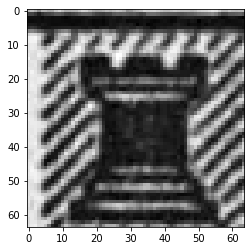

In [11]:
random_index =np.random.randint(0, len(cd))
plt.imshow(cd[random_index][0][0],cmap="gray")
print(cd[random_index][0].shape)

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values
    return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        return focal_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), self.gamma)

class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [13]:
dataloader = torch.utils.data.DataLoader(cd, batch_size=4,shuffle=True, num_workers=0)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [88]:
epochs = 1

In [89]:
loss_fun = FocalLoss(gamma=2)

In [90]:
def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points

    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.

    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.

    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

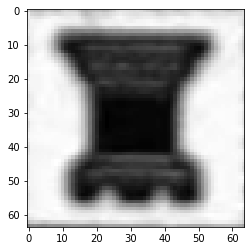

tensor([[-1.3626, -0.3336, -1.9024, -0.3195, -1.8486,  1.6424, -2.8250, -4.3212,
         -4.1789, -4.6896, -2.4383, -0.1558, -1.9648],
        [-1.4272, -2.0797, -4.4182, -6.4432, -2.3148, -3.8812, -0.6843,  4.5488,
         -0.7179, -0.6115, -2.2120, -0.6422, -4.9568],
        [-0.2631, -3.9713, -4.4059, -2.5199, -3.2158, -4.8291, -0.7450,  0.1578,
          1.8503,  3.5143, -4.6574, -3.9189, -2.0353],
        [-2.2933, -0.1628,  2.8031,  1.0159, -3.4060, -1.2056, -1.3822, -3.6232,
         -3.3873, -4.4381, -2.8929, -2.5044, -2.7997]],
       grad_fn=<AddmmBackward>) tensor([5, 7, 9, 2])
acc 1.0


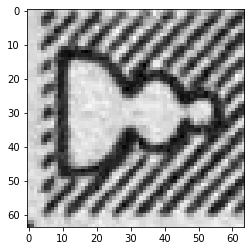

tensor([[-0.7302, -5.3770, -3.5882, -1.9870, -4.8686, -7.4047,  0.5833,  2.1007,
          2.7864,  5.7282, -5.5782, -5.1427, -1.8076],
        [-0.8570, -0.3535, -2.3135, -2.2152, -0.4176,  2.0432, -3.1908, -4.3050,
         -4.5560, -5.0771, -2.3434, -1.7445, -3.1838],
        [-2.5810, -0.5451, -2.6739, -4.0872, -2.1482, -1.9064, -1.1255, -0.1382,
         -2.4193, -3.5399, -0.0824,  2.8715, -3.5106],
        [-0.9898, -0.3893, -0.9744, -1.8747, -1.0370,  2.2473, -3.4641, -2.8300,
         -3.1379, -4.7649, -2.6959, -1.7470, -3.9875]],
       grad_fn=<AddmmBackward>) tensor([ 9,  5, 11,  5])
acc 1.0


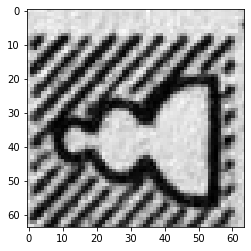

tensor([[-0.3792, -3.6334, -3.3330, -1.4962, -5.1824, -5.4958, -1.1113,  0.6415,
          2.1605,  3.9633, -5.9892, -3.1630, -0.6262],
        [-1.5194, -2.6400, -2.4551, -2.1137, -4.3938, -4.1206, -1.5745,  0.3009,
          3.4008,  1.7384, -4.8552, -2.0100, -2.9439],
        [-0.9219,  0.6332, -1.5664, -0.6546, -1.2873,  3.3583, -4.4273, -3.4863,
         -5.5508, -5.8202, -3.9919, -0.7064, -2.4423],
        [-2.9400, -1.9294, -1.2997, -4.8979,  1.2734, -1.2281,  0.4898, -1.5995,
         -4.8620, -5.8205,  4.0680, -0.3025, -5.2242]],
       grad_fn=<AddmmBackward>) tensor([ 9,  8,  5, 10])
acc 1.0


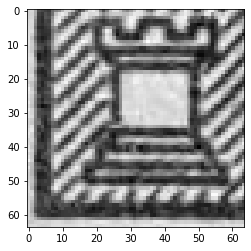

tensor([[-2.1126e+00, -8.1334e-01, -2.4901e+00, -2.0563e+00, -4.1954e+00,
         -2.6128e+00, -1.0769e+00, -1.0760e+00, -5.2476e-01, -1.1199e-01,
         -3.8880e+00,  1.1579e+00, -6.1990e-01],
        [-1.4799e+00,  3.2075e-01, -1.2463e+00, -3.0619e+00, -8.7359e-01,
          2.2523e+00, -1.8946e+00, -9.6087e-01, -5.3922e+00, -5.8495e+00,
         -5.9713e-01, -4.3744e-01, -4.1624e+00],
        [-3.5734e-01, -1.0125e+00,  1.8229e-03,  2.8398e+00, -5.7675e+00,
         -2.7868e+00, -2.2046e+00, -3.3443e+00, -1.8015e+00, -9.3193e-01,
         -6.5482e+00, -3.4117e+00,  8.4850e-01],
        [-4.6094e-01, -4.3063e+00, -2.6492e+00, -4.4823e+00,  3.6738e+00,
         -1.5942e+00, -2.3169e+00, -6.4194e-01, -1.4887e+00, -2.7363e+00,
          6.6613e-01, -3.8084e+00, -7.1306e+00]], grad_fn=<AddmmBackward>) tensor([11,  5,  3,  4])
acc 1.0


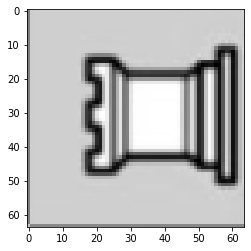

tensor([[-2.7861, -2.1065, -5.1070, -5.6683, -2.0100, -1.2022, -2.5145, -0.7116,
         -0.3529, -1.0108, -2.3028,  3.3465, -2.4194],
        [-0.6282, -1.3632, -0.7400,  2.5811, -4.0866, -1.0039, -2.8468, -4.1593,
         -2.6626, -2.1208, -5.3337, -2.9965, -0.5071],
        [-1.5325, -4.7413, -1.3323, -2.7821, -2.0285, -5.3838,  2.3773, -0.0519,
         -0.8768,  0.2072, -0.8196, -4.5553, -2.4714],
        [-1.1072,  1.9055, -1.8436, -2.6030, -2.7438, -0.5156, -2.5110,  0.1868,
         -4.8570, -4.4019, -2.7975, -2.4363, -3.4711]],
       grad_fn=<AddmmBackward>) tensor([11,  3,  6,  1])
acc 1.0


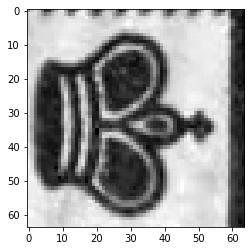

tensor([[-1.2437,  2.5060, -2.3560, -2.9933, -2.4641,  0.9529, -1.7852, -0.9781,
         -6.7072, -7.5003, -1.1139,  0.3637, -3.1642],
        [-2.2596, -2.5335, -2.5154, -3.4211, -2.6088, -2.7122,  0.6130, -0.9513,
         -1.1509, -2.1308, -1.0997, -1.0118, -2.9479],
        [-0.2303, -4.3842, -3.2014, -1.8762, -4.2155, -4.9500, -0.7656, -0.3988,
          2.2278,  3.1865, -5.7739, -5.0171, -1.6003],
        [-2.0252, -3.2596, -2.2800, -1.3047, -4.2956, -4.0573, -1.9668, -0.2276,
          0.1225,  2.8963, -5.0790, -1.8325,  0.1392]],
       grad_fn=<AddmmBackward>) tensor([1, 6, 9, 9])
acc 1.0


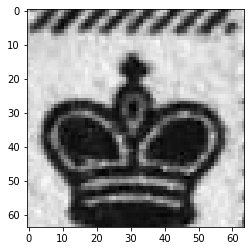

tensor([[-2.5524,  2.8278, -0.0304, -2.0774, -3.1054,  0.2609, -1.4780, -0.6079,
         -7.6732, -7.1256, -1.8805, -1.1598, -3.6291],
        [ 0.1690, -1.3549, -2.7743,  0.1435, -3.1014, -2.6799, -1.2784, -4.8982,
         -2.6751, -0.5505, -3.6666, -0.9526,  4.0705],
        [-1.7739, -4.1176, -3.6057, -4.0800, -2.6914, -2.9453, -1.7745,  0.9415,
          2.3188,  1.0276, -2.7587, -0.2278, -3.7582],
        [-1.0218, -4.0352, -2.4295, -2.5064, -2.6346, -3.2237, -1.0636,  1.2254,
          2.7476,  1.3712, -3.4865, -4.1842, -5.1053]],
       grad_fn=<AddmmBackward>) tensor([ 1, 12,  8,  8])
acc 1.0


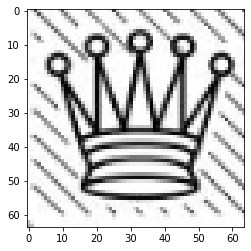

tensor([[-1.7765, -1.8089, -2.8374, -3.5274,  0.0155, -1.5802, -0.3551, -1.0554,
         -2.3804, -2.5749,  1.0493, -0.5645, -2.1003],
        [-2.2511, -0.8591, -2.3736, -3.7553, -1.4265, -2.0427, -0.0358, -0.9804,
         -3.0873, -3.0553,  0.5015, -0.2765, -2.6727],
        [-0.7024, -2.2190, -3.8285, -3.3588,  1.6970,  0.2467, -3.1033, -1.1031,
         -3.0643, -2.7562, -0.8022, -1.4921, -2.8191],
        [-1.3266, -0.7307,  2.0824,  1.7552, -5.5334, -1.6278, -3.5584, -2.3354,
         -2.0373, -2.3350, -7.9021, -3.9214, -3.1387]],
       grad_fn=<AddmmBackward>) tensor([10, 10,  4,  2])
acc 1.0


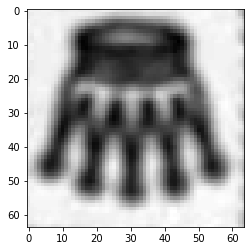

tensor([[-2.3204, -4.0706, -3.4714, -5.0981,  1.5076, -2.0932, -1.1876, -0.9745,
         -0.9305, -1.0208,  1.4883, -1.3320, -2.9126],
        [-3.8813, -1.4025, -2.8761, -4.2728, -3.1459, -1.9521, -0.9379,  1.2187,
         -1.4129, -2.6990, -1.1566,  3.1645, -3.6633],
        [-2.0684, -0.9820,  1.1073,  3.9675, -4.1308, -1.2846, -2.4771, -3.8459,
         -3.4702, -2.3018, -5.0595, -4.0358, -0.9931],
        [ 3.4955, -0.3285, -2.9577, -1.4567, -3.4397, -1.4580, -2.0966, -1.7821,
         -3.4510, -3.2706, -5.9848, -4.4442, -2.0021]],
       grad_fn=<AddmmBackward>) tensor([10, 11,  3,  0])
acc 0.75


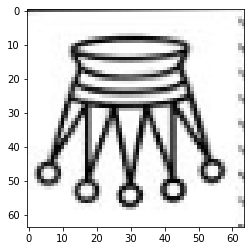

tensor([[-2.0749, -2.9031, -2.0638, -5.5586,  1.8560, -1.4480, -0.3445,  0.6610,
         -2.5208, -4.2022,  2.6569, -1.8870, -6.1904],
        [ 0.4840, -0.4595, -2.2255,  0.8461, -4.5984, -3.1661, -0.6593, -3.6131,
         -1.5511,  0.7221, -5.3375, -1.9630,  4.8251],
        [-0.3823, -0.5589,  0.2507,  2.8948, -5.8792, -0.9850, -4.0088, -1.9170,
         -2.4502, -2.2329, -9.3987, -4.2703, -3.8170],
        [-3.2853, -2.7318, -2.3610, -5.1059,  0.5266, -2.1441,  0.5392,  0.1093,
         -2.8338, -2.7189,  3.8503,  0.8129, -2.9126]],
       grad_fn=<AddmmBackward>) tensor([10, 12,  3, 10])
acc 1.0


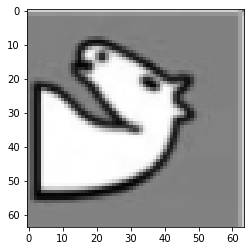

tensor([[-1.1407, -3.4076, -3.5112, -2.2463, -3.5581, -3.8736, -2.1190,  0.8859,
          3.5032,  2.9030, -5.2126, -2.6950, -1.6561],
        [-0.9562, -3.5233, -3.1130, -4.2108, -2.4765, -3.7421,  1.8904, -0.3268,
         -1.3530, -1.4158, -0.6700, -2.7042, -2.6943],
        [-1.5984, -0.8974,  2.9820,  1.9910, -3.7904, -1.4421, -3.0165, -4.3875,
         -4.3096, -4.2907, -4.8652, -4.5356, -2.5626],
        [-2.2356, -0.5517, -4.7596, -4.3935, -1.3548,  0.5126, -1.7626, -0.6824,
         -4.0266, -3.7789, -0.1936,  3.0209, -1.8017]],
       grad_fn=<AddmmBackward>) tensor([ 8,  6,  2, 11])
acc 1.0


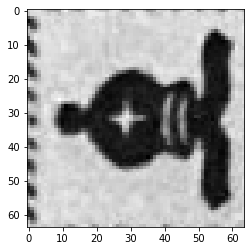

tensor([[ 3.0159, -3.2922, -3.2676, -2.3322, -2.0727, -2.5232, -1.7336, -1.5055,
         -0.3071, -1.4320, -3.8810, -3.5014, -3.3011],
        [-3.4251,  1.6588, -1.6755, -3.6760, -2.3560, -0.0672, -1.9195, -0.1322,
         -4.9168, -4.6366, -0.9160, -0.1824, -2.5468],
        [-1.6095, -0.5922, -0.6060,  1.9379, -4.1036, -0.9077, -3.5756, -3.2367,
         -3.2283, -2.1029, -5.3901, -1.7409, -0.4086],
        [-2.2586, -4.1299, -3.1875, -3.5604, -3.6767, -5.6116,  2.0791,  0.0734,
         -0.4671,  0.7246, -2.1101, -3.0652, -1.4343]],
       grad_fn=<AddmmBackward>) tensor([0, 1, 3, 6])
acc 1.0


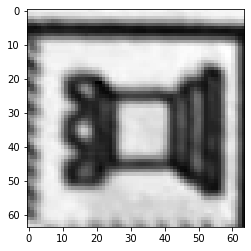

tensor([[-2.6773, -0.5645, -4.3880, -3.8485, -1.2138,  0.1701, -3.2398, -0.8176,
         -1.7950, -2.0333, -1.2321,  2.8489, -1.2244],
        [-1.3966, -3.5006, -3.5907, -1.2186, -3.2715, -4.8806, -0.2913, -0.5285,
          0.7639,  3.2359, -3.7935, -3.2447,  1.1937],
        [-2.9207, -1.0685,  4.1042,  0.6991, -3.3721, -1.7119, -2.0045, -2.5679,
         -4.5132, -5.3299, -3.0235, -4.7493, -5.4110],
        [ 2.6565, -1.8026, -4.3059, -2.1211, -1.8431, -0.9960, -1.7938, -1.5948,
         -2.4464, -2.8035, -2.8805, -2.2461, -2.3829]],
       grad_fn=<AddmmBackward>) tensor([11,  9,  2,  0])
acc 1.0


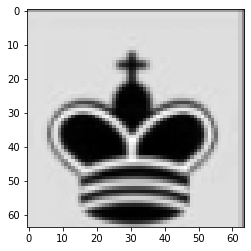

tensor([[-0.3809,  1.7474,  0.3374, -0.3536, -3.8459, -0.5352, -2.2210, -4.3793,
         -6.8021, -5.9014, -4.1344, -3.3969, -1.6069],
        [-2.6541, -4.6025, -2.5584, -2.9099, -4.1596, -4.6604, -0.0702,  1.4655,
          3.9622,  1.9908, -3.1342, -3.4932, -4.5012],
        [-1.1699,  1.7769, -2.2877, -2.2295, -1.5473,  0.9080, -2.4402, -1.6136,
         -6.7920, -5.6173, -1.7742, -0.1666, -1.6001],
        [-1.2126, -4.3899, -3.9444, -3.4559, -2.3137, -3.2738, -1.4428, -0.2685,
          2.1446,  1.8134, -2.5415, -0.2831, -0.4994]],
       grad_fn=<AddmmBackward>) tensor([1, 8, 1, 8])
acc 1.0


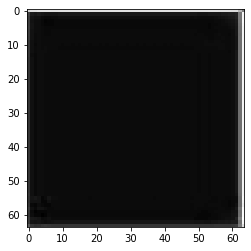

tensor([[-0.4196, -1.6556, -1.8047,  0.4025, -3.0087, -3.2329, -0.5212, -3.8435,
         -1.8117,  0.6732, -2.7317, -1.4645,  5.0754],
        [-1.8706,  0.7814, -2.5678, -3.9602, -2.2550, -0.7793, -1.0627,  0.4032,
         -3.7039, -3.6437, -1.3870, -1.3808, -3.3898],
        [-2.2297, -2.5926, -5.6810, -4.4388, -1.3242, -0.5634, -1.0483,  0.3080,
         -1.3961, -2.0251, -0.1946,  2.3507, -3.5493],
        [-1.1435, -2.3388,  3.1460,  0.5748, -3.3835, -2.4294, -2.9886, -2.3030,
         -2.0149, -3.6421, -4.9092, -6.2795, -6.1602]],
       grad_fn=<AddmmBackward>) tensor([12,  1, 11,  2])
acc 1.0


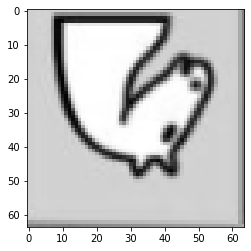

tensor([[-1.7934, -3.3415, -2.2245, -2.3759, -4.0652, -4.3568, -0.2155,  0.2155,
          3.5726,  1.3800, -4.0948, -3.4648, -2.7455],
        [-1.8091, -0.2763, -1.6018, -5.3740,  2.7741,  0.7667, -1.2159, -1.8291,
         -6.8183, -6.7749,  3.8683,  0.0751, -3.6701],
        [-1.2964, -3.2349, -3.6700, -3.5957, -3.3292, -4.1640, -1.6199,  0.6686,
          1.1828,  2.1340, -3.3783,  0.3358, -0.0251],
        [-0.3448, -0.3619,  0.0712,  4.2673, -5.8752, -0.5029, -3.1451, -4.6099,
         -3.7701, -3.1467, -7.3009, -4.3203, -1.5597]],
       grad_fn=<AddmmBackward>) tensor([8, 4, 9, 3])
acc 0.75


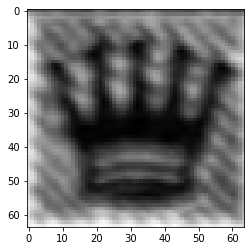

tensor([[-1.5524, -2.1990, -2.7436, -4.9373,  1.7425, -0.3964, -3.2733, -0.8156,
         -3.0638, -3.6344,  1.4245,  0.7298, -3.1675],
        [-1.0494, -1.2815, -1.4596, -0.2961, -5.2936, -3.3032, -1.6929, -2.5317,
         -0.1723,  1.3286, -4.9377,  0.1481,  3.2954],
        [ 0.1215, -2.6565, -4.3711, -0.0387, -7.5229, -4.8927,  0.0883,  0.1894,
          1.8705,  3.5743, -8.5501, -4.9986, -0.2009],
        [-3.8489, -0.8331,  0.7362, -3.5057,  1.3297, -0.4587,  0.1148, -1.9433,
         -5.4291, -7.3080,  4.1166, -2.3840, -5.7331]],
       grad_fn=<AddmmBackward>) tensor([ 4, 12,  9, 10])
acc 1.0


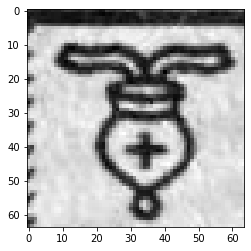

tensor([[-1.7140, -3.0158, -1.6539, -5.0752, -2.2167, -3.3041,  2.6685,  0.5602,
         -3.1071, -4.6143,  1.1244, -3.5709, -5.2106],
        [-0.9881, -0.6465, -0.7728,  1.9932, -3.1838,  0.1454, -3.5125, -3.1175,
         -3.0827, -2.5353, -4.5327, -2.0246, -1.3021],
        [-2.1310, -4.2090, -3.7961, -3.5404, -3.9722, -4.2616, -1.3973,  0.5958,
          2.3468,  3.2736, -4.6511, -2.4482, -2.0050],
        [-1.7227, -0.2601, -1.9185, -1.3181, -2.9277, -2.5022, -1.7363, -3.2299,
         -2.6192, -0.3501, -1.8506,  0.3509,  4.5237]],
       grad_fn=<AddmmBackward>) tensor([ 6,  3,  9, 12])
acc 1.0


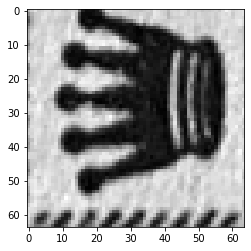

tensor([[-0.0234, -1.3995, -1.1290, -2.7484,  2.2012,  1.0129, -3.7717, -2.0556,
         -5.4558, -5.6622, -0.3878, -3.0690, -5.1879],
        [-0.3118, -0.8138, -2.3945,  0.0924, -4.7407, -3.1619, -0.1895, -3.9579,
         -2.3213,  0.1432, -3.8978, -0.9081,  5.1002],
        [-4.1506, -1.2368, -2.2418, -4.6306,  0.1832, -1.5477, -0.2301, -0.0288,
         -3.7950, -4.0994,  3.1787,  0.3407, -3.2739],
        [-1.7479, -2.9199, -2.6193, -1.7904, -6.5147, -4.0219, -1.3344,  2.2002,
          4.5978,  2.3477, -6.7745, -2.8252, -3.8955]],
       grad_fn=<AddmmBackward>) tensor([ 4, 12, 10,  8])
acc 1.0


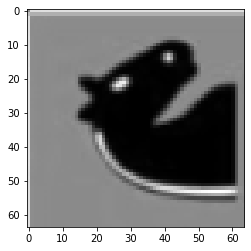

tensor([[-0.9866, -1.3344,  3.1637,  2.3201, -2.9885, -1.5818, -3.9144, -5.7068,
         -2.8856, -3.2852, -5.2055, -4.8701, -1.1513],
        [-1.7193, -2.7221, -3.3393, -3.5549, -3.1544, -3.4029,  0.0179,  1.4353,
         -0.9732, -0.2188, -2.1736, -2.0344, -2.5886],
        [-1.4962, -2.0939, -4.1956, -3.9382, -1.6378, -2.7408, -1.1517,  2.4597,
         -0.7335, -0.6503, -1.3205, -1.3356, -3.1212],
        [-2.7196, -0.9082, -4.2574, -4.7947, -1.8849,  0.0893, -1.4486, -2.4940,
         -2.6970, -4.4315, -0.8112,  2.8559, -3.0336]],
       grad_fn=<AddmmBackward>) tensor([ 2,  7,  7, 11])
acc 1.0


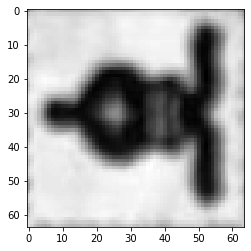

tensor([[ 0.8244, -1.4606, -2.8046, -1.3343, -2.4298, -1.6926, -2.2736, -2.9478,
         -2.0075, -1.7579, -3.4248, -1.3546, -0.5131],
        [-2.6457, -2.0428, -3.1920, -5.8421, -1.7973, -3.9247, -0.7954,  3.8513,
         -0.8686, -0.9741, -0.7654, -1.8687, -4.9419],
        [-0.8710,  0.0910, -1.3805, -0.0689, -1.1150,  3.3533, -4.9194, -5.5198,
         -4.7016, -6.0457, -3.9411, -1.5980, -2.8124],
        [-2.3413, -3.7537, -1.4870, -2.1186, -4.2987, -5.2696,  2.4586, -1.7586,
         -0.0370, -0.2195, -1.4195, -2.6708, -1.0357]],
       grad_fn=<AddmmBackward>) tensor([0, 7, 5, 6])
acc 1.0


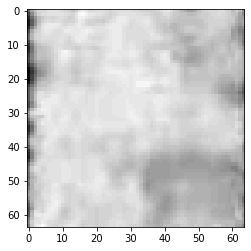

tensor([[-1.2860, -1.5099, -2.3774, -1.4149, -2.7209, -2.8479, -0.4736, -3.5378,
         -1.9017, -0.1240, -1.7227, -0.6247,  3.4823],
        [-1.6680, -0.9434,  0.6734,  3.5004, -2.8919,  0.5725, -3.1644, -3.3082,
         -3.1711, -3.1945, -3.8767, -3.5556, -2.9248],
        [-1.6120, -2.5241, -2.7473, -6.2970, -3.1257, -4.7537, -0.2962,  5.3698,
         -0.1682, -0.7677, -2.9928, -3.9869, -6.6683],
        [-1.3012, -1.3147, -2.4084, -1.6093, -2.6758, -2.8077, -0.4525, -3.2979,
         -2.0008, -0.2635, -1.5534, -0.4375,  3.4327]],
       grad_fn=<AddmmBackward>) tensor([12,  3,  7, 12])
acc 1.0


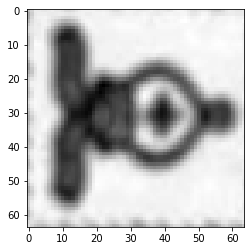

tensor([[-1.3377, -3.3119, -5.6261, -4.8901, -1.6518, -3.0966,  1.3467, -1.2350,
         -0.4709, -0.2639,  0.1433, -1.4367, -0.3561],
        [-0.5204, -1.0821, -2.5028,  1.3334, -3.4372, -1.3182, -3.0805, -3.1164,
         -2.3523, -1.2661, -5.1926, -1.7494, -1.1657],
        [-1.6524, -1.4864, -0.0145, -2.5393, -0.9041, -2.1301, -1.4244, -2.2261,
         -3.4554, -3.5731, -0.7246, -1.7016, -2.7123],
        [-1.8832, -0.3774,  2.4287, -0.1488, -2.8301, -1.8100, -3.4032, -1.7624,
         -3.4693, -4.3732, -4.4932, -4.2698, -3.2577]],
       grad_fn=<AddmmBackward>) tensor([6, 3, 2, 2])
acc 1.0


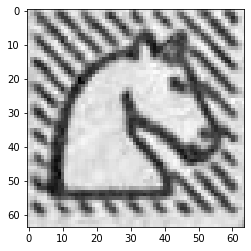

tensor([[-1.8008, -4.9554, -1.8333, -2.5116, -3.3140, -5.3985,  0.2102, -0.3429,
          3.2421,  2.4306, -2.6573, -2.8303, -2.1241],
        [-2.2166, -4.1907, -2.6702, -2.9307, -4.6737, -5.1063,  0.1522, -0.0896,
          3.5117,  2.1520, -3.6448, -3.4208, -2.1898],
        [-0.8377,  1.9401, -0.9045, -1.9234,  1.7721,  3.7471, -6.1631, -4.4334,
         -7.7405, -7.8868, -2.1942, -1.6364, -3.2336],
        [-1.8166, -0.0570, -3.2828, -3.6845, -2.3639,  0.3327, -1.3023, -1.1108,
         -4.8427, -5.1136, -0.8617,  2.4356, -1.9937]],
       grad_fn=<AddmmBackward>) tensor([ 8,  8,  5, 11])
acc 1.0


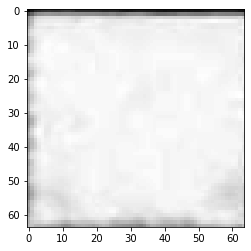

tensor([[-1.4778, -1.5378, -2.4491, -2.0495, -2.7372, -3.6342,  0.2875, -2.6066,
         -1.6694, -0.1775, -0.9274, -0.8357,  3.4560],
        [-0.2960, -0.7967, -3.5909, -1.9329, -3.9054, -3.1449, -0.7284, -1.6168,
         -0.8569, -0.2504, -3.8557, -0.2268,  1.7113],
        [-1.3540, -0.5019, -1.5690, -3.9111,  2.4741,  3.1825, -2.8134, -1.2130,
         -5.9355, -6.2597,  0.1028, -3.1400, -6.5124],
        [-1.8497, -2.4530,  1.6437,  2.5173, -5.2386, -3.4041, -3.0757, -2.6248,
         -1.7584, -1.3566, -6.0345, -4.4616, -2.4083]],
       grad_fn=<AddmmBackward>) tensor([12, 12,  5,  3])
acc 1.0


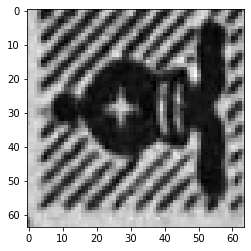

tensor([[ 3.8014, -1.4247, -1.0521,  0.0679, -0.7872, -1.3346, -5.7360, -3.2154,
         -1.9886, -2.4636, -5.5795, -4.2301, -2.7973],
        [-2.0820, -3.7441, -2.8804, -1.4727, -5.1608, -5.1120,  0.9603, -0.5523,
          1.4104,  3.5505, -4.2692, -3.6949,  0.2040],
        [-4.6006, -0.2137, -4.2992, -5.2663, -2.1716,  0.4287, -2.5018, -0.8899,
         -2.7476, -3.7902, -0.8525,  4.2867, -1.4118],
        [-2.9423, -2.5011, -1.0862, -2.5478, -2.7011, -3.3251,  2.5431, -1.5496,
         -3.0596, -2.5335,  0.1335, -3.0234, -1.7835]],
       grad_fn=<AddmmBackward>) tensor([ 0,  9, 11,  6])
acc 1.0


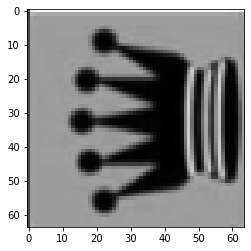

tensor([[-2.0302, -0.9806, -0.7057, -2.6875,  1.4686, -0.6939, -2.8547, -2.5359,
         -3.9967, -4.1595, -0.0478, -1.7902, -2.9397],
        [-1.3957, -1.7660, -2.9743, -2.8779, -5.9175, -4.2485,  0.1174,  2.8385,
          0.3361,  0.1022, -4.4251, -1.8479, -3.3156],
        [-0.7349, -0.5235, -1.5103, -0.5723, -3.7068,  1.4087, -4.2292, -4.2250,
         -2.0151, -3.4730, -5.4207, -1.2273, -2.2513],
        [-1.6796, -2.1095, -1.2458, -2.7371,  2.5694, -0.4946, -2.4883, -3.2264,
         -4.2796, -4.5030,  0.7382, -2.5846, -2.8647]],
       grad_fn=<AddmmBackward>) tensor([4, 7, 5, 4])
acc 1.0


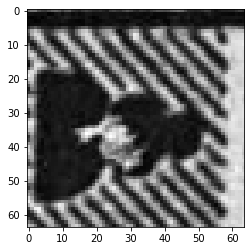

tensor([[ 0.0113,  0.1656,  0.5599,  1.6135, -1.0933, -0.1413, -5.6145, -4.5937,
         -6.2380, -5.6212, -4.8953, -3.3714, -2.3091],
        [-0.8586, -3.6858, -3.1431, -1.8990, -4.4043, -5.1690, -0.1336, -0.1777,
         -0.2469,  2.8555, -3.5334, -2.6242,  1.0667],
        [-2.1675, -2.1564, -2.7095, -3.3184, -3.4801, -2.4624, -0.2307, -0.3608,
          1.1457, -0.9359, -2.3974, -1.0441, -3.0718],
        [-3.2643, -3.0208, -3.2587, -4.9769, -2.7565, -3.0554,  0.2428, -0.2358,
          1.4060, -1.2263, -0.4632, -0.5311, -2.7808]],
       grad_fn=<AddmmBackward>) tensor([3, 9, 8, 8])
acc 1.0


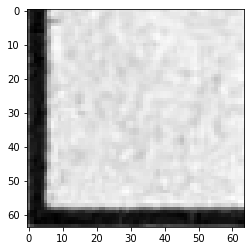

tensor([[-0.4748, -0.1622, -3.9124, -1.3145, -2.7606, -1.4708, -1.9506, -3.7121,
         -3.7851, -1.9146, -3.0674,  0.1607,  3.3993],
        [-2.4068, -3.1978, -1.7060, -1.7359, -3.4927, -3.4278, -2.0583, -1.2670,
          2.7211,  0.9994, -3.7248, -2.3109, -2.2577],
        [-2.5607, -1.4833, -2.0529, -3.8166, -2.5781, -2.7631, -1.0716,  2.7317,
         -2.3337, -2.0652, -2.4253, -2.2193, -4.3243],
        [-0.7115, -2.0193, -1.1728, -2.7377, -2.3297, -2.3778, -0.0881, -2.2719,
         -3.3875, -3.0796, -1.5344, -3.2567, -2.8011]],
       grad_fn=<AddmmBackward>) tensor([12,  8,  7,  6])
acc 1.0


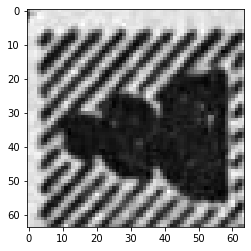

tensor([[-1.4467e+00, -1.1741e+00, -7.6145e-05,  1.7838e+00, -3.6172e+00,
         -1.6790e+00, -3.1755e+00, -3.0318e+00, -1.3509e+00, -1.1244e+00,
         -5.8263e+00, -2.0934e+00, -1.1072e+00],
        [ 1.4815e+00, -2.4961e+00, -3.7624e+00, -3.9327e+00, -1.7963e+00,
         -2.9251e+00, -1.4315e+00,  5.3755e-01,  7.8376e-01, -5.9290e-03,
         -2.9075e+00, -1.5102e+00, -1.3575e+00],
        [-2.8343e+00, -1.8998e+00, -1.9971e+00, -5.5066e+00,  1.9114e+00,
         -1.8127e+00,  5.9450e-01, -1.1143e+00, -4.3250e+00, -4.2649e+00,
          4.4998e+00, -1.4253e-01, -2.7431e+00],
        [-7.8607e-01, -3.0701e-01, -2.4423e-02,  2.7569e+00, -5.2629e+00,
         -1.1394e+00, -2.7371e+00, -4.4759e+00, -3.2942e+00, -3.2427e+00,
         -7.5028e+00, -5.6466e+00, -2.2657e+00]], grad_fn=<AddmmBackward>) tensor([ 3,  0, 10,  3])
acc 1.0


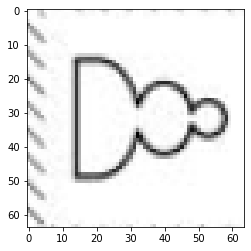

tensor([[-2.1554, -4.3451, -4.5554, -2.4720, -6.1474, -5.2936,  1.9071, -0.3230,
          2.5828,  3.2422, -4.0841, -3.2335, -0.1431],
        [ 0.3707, -0.6101, -1.4385, -2.5446,  4.3558,  1.7843, -4.9075, -3.2375,
         -5.2481, -5.4143, -0.3549, -3.6008, -3.7373],
        [-3.1325, -0.8439, -4.7140, -5.6789, -1.9268, -1.5841, -1.2940, -0.1859,
         -2.1223, -2.7261, -0.1176,  3.8339, -0.9948],
        [-2.0959, -0.9905,  3.8850,  1.3366, -3.8240, -1.5997, -2.7278, -3.3143,
         -2.7523, -4.0059, -5.2770, -3.6712, -3.9245]],
       grad_fn=<AddmmBackward>) tensor([ 9,  4, 11,  2])
acc 1.0


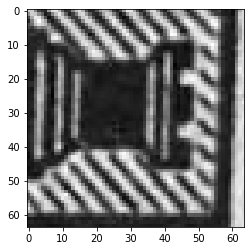

tensor([[-1.1971,  1.1486, -1.1023, -0.8290,  0.4890,  3.0022, -5.0756, -3.3149,
         -6.2367, -5.9931, -3.3091, -0.7362, -3.1874],
        [-3.5470, -1.3942, -2.4068, -4.5010, -4.4455, -4.6138,  1.0413,  2.4142,
         -1.3252, -1.2971, -1.7050, -1.2384, -2.4764],
        [-2.2282, -4.6488, -3.0856, -3.2407, -2.8462, -3.9743,  0.0179, -0.0986,
          3.8674,  1.6736, -2.0225, -2.5544, -3.3585],
        [ 2.4072, -1.8167, -1.2299,  0.0567, -2.5981, -2.2427, -2.4422, -4.7999,
         -2.7234, -3.2086, -4.4603, -4.2078, -0.8455]],
       grad_fn=<AddmmBackward>) tensor([5, 7, 8, 0])
acc 1.0


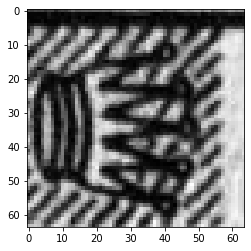

tensor([[-1.5827, -0.7773, -0.5221, -3.1863,  2.6959,  0.5418, -2.7767, -3.6949,
         -6.0928, -6.1534,  2.0152, -1.4287, -3.3784],
        [-0.3793, -2.1245, -2.3002, -1.0057, -3.0977, -3.0517, -1.5112, -3.3869,
         -0.3616,  0.6470, -3.2353,  0.0694,  4.0263],
        [-3.0279, -0.1712, -2.2984, -4.3528, -3.2056, -2.3977, -1.1345,  2.8660,
         -1.8744, -3.4773, -2.7204, -1.6668, -6.1307],
        [-1.5245, -3.5723, -3.4893, -0.8290, -6.3738, -4.6269,  0.2735, -0.6368,
          1.8788,  2.7498, -6.1616, -4.4640, -1.8843]],
       grad_fn=<AddmmBackward>) tensor([10, 12,  7,  9])
acc 0.75


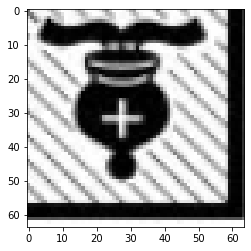

tensor([[ 2.7899, -1.6454, -3.1607, -1.1749, -3.0482, -1.8972, -1.8540, -2.1194,
         -1.8369, -2.2078, -4.9367, -4.1802, -1.8783],
        [-1.2165,  0.8956, -1.5789, -1.5475, -0.3291,  3.0297, -3.9344, -3.5885,
         -6.1061, -6.6532, -2.8738, -1.0921, -3.7740],
        [-1.8865,  0.5258, -1.2687, -2.3713, -0.5363, -0.1508, -3.9129, -2.2796,
         -3.9073, -4.1692, -2.3708, -0.6080, -2.0421],
        [-3.9626, -5.1173, -2.0218, -2.8315, -4.4466, -5.9006,  1.5613, -0.3819,
          4.1803,  1.9140, -1.5928, -2.0307, -2.3393]],
       grad_fn=<AddmmBackward>) tensor([0, 5, 1, 8])
acc 1.0


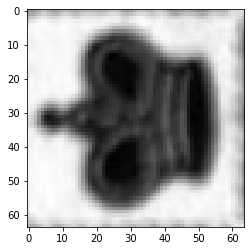

tensor([[-3.9852,  0.5843, -2.1627, -2.2579, -1.6403,  0.3082, -3.4510, -2.0890,
         -3.4624, -3.4690, -1.8704,  1.0658, -1.4070],
        [-3.4456, -2.8034, -1.4031, -1.0956, -2.5305, -3.0060,  1.6747, -1.4409,
         -1.4252, -0.7054, -0.6205, -2.8074, -0.8265],
        [ 2.2477, -1.7149, -2.4927, -1.7689, -3.3927, -2.9481, -2.1403, -1.9964,
         -1.9820, -1.9858, -5.6212, -4.3603, -2.2459],
        [ 2.2668, -1.4703, -1.5848, -1.1155, -2.4972, -2.1446, -2.4765, -2.4662,
         -2.1499, -2.8002, -4.5169, -3.7496, -2.9178]],
       grad_fn=<AddmmBackward>) tensor([1, 6, 0, 0])
acc 0.75


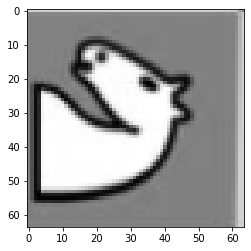

tensor([[-2.1021, -3.1056, -3.1205, -2.8603, -3.7661, -4.1970, -0.6981,  0.9603,
          4.2554,  2.0970, -4.1048, -1.5963, -1.9384],
        [-1.0906, -0.6144,  1.0716,  4.1582, -4.4531, -1.2954, -4.1227, -4.5191,
         -4.0154, -2.7939, -7.2860, -4.5119, -1.7565],
        [-4.1283, -1.9721, -1.3937, -4.8176,  1.4356, -1.2537,  0.1257, -1.6589,
         -4.3370, -4.1557,  4.3789,  1.0400, -2.1747],
        [ 3.4604, -0.9465, -3.0651, -2.4351, -2.4507, -2.0548, -1.3391, -2.0344,
         -2.0857, -3.1293, -4.5801, -4.2709, -2.3910]],
       grad_fn=<AddmmBackward>) tensor([ 8,  3, 10,  0])
acc 1.0


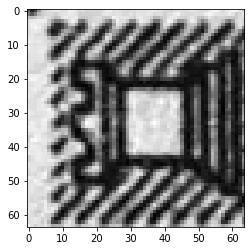

tensor([[-3.5041, -2.2679, -2.2579, -3.0317, -2.2361, -1.6409, -1.5646, -0.8490,
         -0.8329, -1.7745, -1.8311,  1.5055, -2.8437],
        [-4.8569, -2.9258, -0.9274, -4.2028,  0.7643, -2.4970,  0.6327, -1.3515,
         -3.0549, -3.2031,  3.4824, -0.8965, -2.7903],
        [ 4.0204, -1.8890, -2.6594, -1.0385, -3.0801, -2.1949, -2.0827, -1.8790,
         -1.8005, -1.8625, -5.9896, -5.4536, -2.1355],
        [-0.7872,  3.2641, -0.5756,  0.1089, -3.9912, -0.7606, -4.1110, -2.9615,
         -4.8612, -4.0952, -6.0479, -3.5488, -0.5132]],
       grad_fn=<AddmmBackward>) tensor([11, 10,  0,  1])
acc 1.0


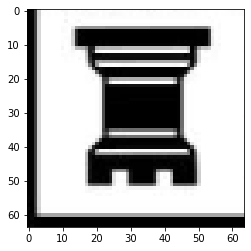

tensor([[-1.0502,  0.5996, -1.3051,  0.0717, -3.2802,  2.5612, -3.8761, -5.2320,
         -5.0555, -6.1642, -4.5409, -1.5964, -2.5647],
        [-1.7364, -1.6801, -3.0917, -4.2834, -1.5703, -3.1042, -1.5378,  1.9806,
         -1.4159, -1.5107, -1.6026, -0.4684, -3.0531],
        [-1.3637, -0.9282, -0.3555, -3.3392,  3.0724, -0.5840, -2.3549, -3.0167,
         -5.0942, -5.5920,  1.2137, -3.1441, -4.1984],
        [-1.4484, -3.4011, -2.5699, -1.0393, -5.7140, -5.1453, -0.3402, -0.1830,
          4.0261,  2.4911, -5.6349, -2.5271, -1.1954]],
       grad_fn=<AddmmBackward>) tensor([5, 7, 4, 8])
acc 1.0


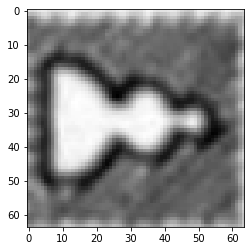

tensor([[-0.6217, -3.2817, -2.6822, -1.4908, -3.8078, -3.5515, -1.8720, -0.6452,
          0.5458,  1.5352, -4.7255, -1.7321, -0.4607],
        [-1.7474, -4.8186, -4.0131, -1.7522, -3.6418, -4.8040,  0.6471, -2.1731,
          1.1715,  2.9361, -3.1989, -2.8623,  0.0758],
        [-3.3233, -1.9587, -3.0915, -4.5268, -2.9515, -2.3754, -0.3009,  2.1677,
         -0.3187, -2.5875, -1.3628, -1.5351, -4.8514],
        [-0.1435,  3.9765,  0.4057, -1.1354, -2.1414,  0.4475, -3.6977, -4.2206,
         -7.8011, -7.6402, -3.5813, -2.8036, -1.8539]],
       grad_fn=<AddmmBackward>) tensor([9, 9, 7, 1])
acc 1.0


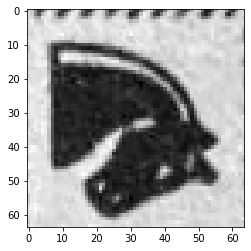

tensor([[-2.8250, -1.1616,  2.6319, -0.5637, -1.6870, -2.2803, -1.6304, -3.4262,
         -2.8144, -3.8921, -1.3311, -3.3755, -3.8003],
        [-2.2353, -2.5723, -2.8872, -4.1880, -4.8173, -5.4912,  0.4344,  3.9969,
          0.5275,  1.1355, -3.6865, -3.3212, -3.5291],
        [-0.8780, -0.7303, -3.0194, -1.4036, -0.1612,  3.2640, -4.2779, -3.5189,
         -3.7776, -4.9236, -3.1969, -1.2663, -4.0032],
        [-0.1211, -1.3765, -2.9645, -0.7691, -2.8732, -3.3989,  0.2436, -3.4871,
         -2.4426, -0.1383, -1.7041, -0.9609,  4.4384]],
       grad_fn=<AddmmBackward>) tensor([ 2,  7,  5, 12])
acc 1.0


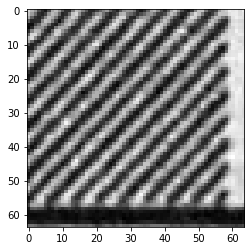

tensor([[ 0.0501, -1.9902, -2.1640,  0.7884, -3.5363, -3.2922,  0.6132, -2.5079,
         -1.4065,  0.9940, -3.2072, -2.5895,  2.9436],
        [-0.7333, -1.9426, -1.5551, -0.9122, -1.9468, -3.0787, -1.9488, -3.0338,
         -0.4757,  0.8976, -2.4556, -1.1890,  3.4359],
        [-0.8952,  2.3786,  0.6548,  0.5197, -4.0563, -1.1275, -3.5913, -2.1860,
         -4.7149, -4.7377, -5.5003, -6.3797, -3.7274],
        [-3.8614, -2.3612, -4.8450, -6.4549, -1.3394, -1.3291, -0.6576,  0.3363,
         -2.3751, -4.3762,  0.2152,  2.5785, -6.8006]],
       grad_fn=<AddmmBackward>) tensor([12, 12,  1, 11])
acc 1.0


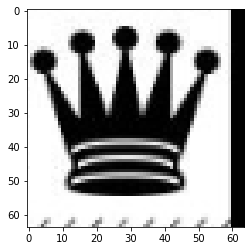

tensor([[-1.5759, -3.4104, -0.8301, -4.2692,  1.8210, -2.3801, -1.1562, -0.9897,
         -1.9940, -3.6619,  1.1587, -3.6006, -5.3247],
        [-1.7626,  1.1646, -1.9913, -3.6443, -1.4873,  1.5108, -1.7052, -1.2210,
         -4.7393, -4.9821, -1.6640,  0.0277, -3.9053],
        [ 0.1511,  0.0710, -3.0614, -1.0199, -3.5331, -2.8844, -0.1302, -2.7923,
         -1.5579, -0.0760, -2.6262, -0.6595,  4.1109],
        [-1.2403, -1.1704,  0.3542,  3.3100, -5.5970, -1.9100, -3.3171, -3.2088,
         -1.8760, -1.3946, -7.5399, -4.4490, -1.8481]],
       grad_fn=<AddmmBackward>) tensor([ 4,  5, 12,  3])
acc 1.0


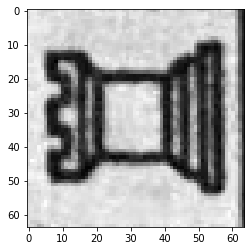

tensor([[-3.7115, -0.9099, -4.4982, -6.3516, -1.5627, -1.3240, -0.2784,  0.1058,
         -2.1841, -2.9766,  0.4318,  3.1029, -2.9747],
        [-0.6645, -1.4730, -0.3428,  3.5417, -4.2664, -1.8676, -3.3414, -4.7132,
         -2.6973, -1.6691, -6.2971, -5.1532, -0.9019],
        [-3.0878, -0.4111,  1.7810, -0.8648, -1.9934, -1.6212, -2.2361, -2.3045,
         -2.7746, -3.3069, -2.3087, -3.0828, -2.4423],
        [ 2.9658, -2.6091, -3.7610, -1.6536, -2.1030, -2.9396, -1.0788, -1.4997,
         -1.1482, -1.1340, -3.7676, -4.3941, -2.3734]],
       grad_fn=<AddmmBackward>) tensor([11,  3,  2,  0])
acc 1.0


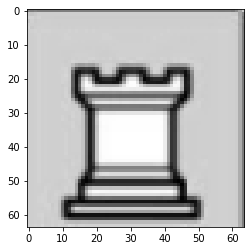

tensor([[-3.2403, -0.7244, -5.1453, -7.6565, -0.8164, -0.8652, -1.0213,  0.1614,
         -1.8868, -2.8950,  0.3527,  3.1670, -2.8387],
        [-1.2826, -2.8653, -0.2216,  0.9081, -3.2143, -3.3043, -0.5417, -2.9885,
         -0.9419, -0.7299, -2.4804, -3.6691, -0.7024],
        [-0.6321, -2.8094, -0.1385,  2.3335, -4.3256, -3.2480, -2.0332, -3.6155,
         -2.9585, -1.4857, -5.8086, -6.3859, -1.7217],
        [-0.2885,  0.4317, -0.7315,  0.7021, -2.9327, -1.0887, -2.8929, -2.8271,
         -3.0637, -2.5923, -4.6723, -3.3079, -0.8043]],
       grad_fn=<AddmmBackward>) tensor([11,  3,  3,  3])
acc 1.0


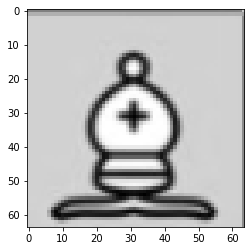

tensor([[-1.7997, -3.1506, -2.2207, -2.9544, -3.6572, -5.7428,  2.8831, -1.2683,
         -0.8750, -0.1769, -1.2164, -3.9227, -0.8426],
        [-2.8168,  0.2246, -0.3150, -0.4506, -0.6564,  3.4051, -4.5482, -3.0051,
         -4.6790, -5.3236, -2.7879, -2.4857, -4.1438],
        [-4.4842, -1.4009, -3.0160, -4.0715, -2.1245, -2.0176, -1.9849, -0.8074,
         -1.7324, -1.7226, -0.8752,  2.9193, -1.3630],
        [ 3.3459, -1.4980, -2.5346, -0.3709, -3.5770, -2.8144, -1.6243, -2.7438,
         -2.2681, -2.0790, -5.7645, -5.2999, -1.5002]],
       grad_fn=<AddmmBackward>) tensor([ 6,  5, 11,  0])
acc 1.0


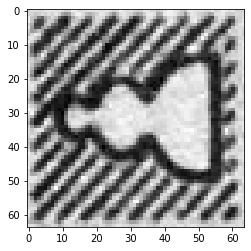

tensor([[-2.9734, -4.6043, -3.0246, -1.8259, -5.3488, -6.3602, -0.2634,  0.8954,
          2.8738,  5.1460, -4.4790, -3.1284, -0.6355],
        [ 2.5358,  0.1160, -2.1225, -0.4694, -3.2101, -1.1335, -3.5486, -2.6687,
         -2.4732, -3.2193, -5.7916, -2.9567, -2.3297],
        [-2.3375, -0.2387, -1.6714, -1.3566,  0.1053,  2.9630, -3.5820, -3.9958,
         -5.9245, -6.6945, -1.5114, -1.2797, -3.9213],
        [-2.4146, -1.6864, -2.2492, -4.1081, -3.2321, -4.4682,  2.3160, -1.3264,
         -1.8579, -1.6876, -0.8007, -2.4526, -1.1664]],
       grad_fn=<AddmmBackward>) tensor([9, 0, 5, 6])
acc 1.0


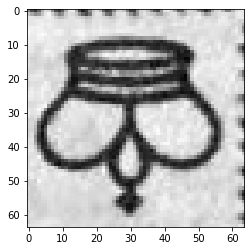

tensor([[-3.6645, -1.4163, -3.8615, -5.6012, -2.0068, -2.8353, -1.2434,  3.5436,
         -0.6658, -1.1936, -1.6596, -1.2222, -6.1953],
        [-0.6036, -0.5509, -1.9283, -0.6537, -2.3862, -2.8182, -1.3412, -3.2245,
         -1.4762,  0.4313, -2.0277, -0.3651,  4.1151],
        [-2.9509, -0.4014,  2.9336,  1.3775, -3.0405, -0.8740, -2.6140, -3.0660,
         -4.2118, -4.1066, -4.0302, -3.6798, -2.8582],
        [ 3.5629, -3.5371, -3.8569, -1.4712, -3.0350, -2.4116, -0.4515, -3.6249,
         -0.6805, -2.3398, -4.6589, -5.0185, -2.9488]],
       grad_fn=<AddmmBackward>) tensor([ 7, 12,  2,  0])
acc 1.0


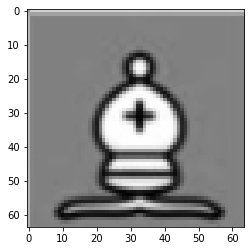

tensor([[-0.9658, -1.7631, -2.9787, -4.2170, -4.1949, -4.9857,  2.3005,  0.1470,
         -0.9114, -0.4695, -2.2529, -2.4268, -0.9392],
        [-2.4593, -2.7463, -1.2099, -3.8736,  3.4177, -0.9637, -2.6578, -1.7731,
         -4.4863, -4.6463,  2.2352, -2.5547, -5.0416],
        [-1.6355, -0.7654,  1.0592,  4.3720, -5.8998, -2.2524, -2.6191, -5.1157,
         -2.3710, -1.4236, -6.5143, -3.2049,  0.3990],
        [-1.2061,  0.9705, -3.2884, -2.7516, -1.3886,  2.3164, -3.7486, -1.0324,
         -3.1839, -4.4148, -3.4217, -0.2469, -3.4031]],
       grad_fn=<AddmmBackward>) tensor([6, 4, 3, 5])
acc 1.0


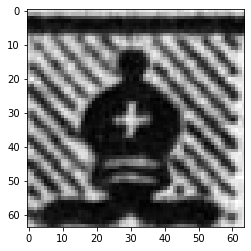

tensor([[ 1.4033, -0.9524, -2.7386, -0.7831, -1.1484, -1.2584, -2.4978, -2.2085,
         -3.4390, -2.8647, -2.8877, -3.0177, -1.8811],
        [-4.5530, -0.9412,  4.3072,  0.2765, -2.6095, -2.1250, -2.1700, -3.8385,
         -4.1041, -5.6613, -2.3489, -4.2614, -4.9638],
        [ 2.1033, -1.1393, -4.2842, -2.7519, -2.3247, -1.2626, -1.0996, -2.4335,
         -1.5792, -2.5042, -3.1293, -1.9983, -1.8232],
        [-1.8615, -2.8136, -4.8025, -2.2803, -4.6004, -4.9950, -0.5968,  0.5982,
          1.3351,  4.2363, -4.6963, -1.8047,  1.2938]],
       grad_fn=<AddmmBackward>) tensor([0, 2, 0, 9])
acc 1.0


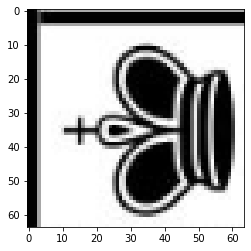

tensor([[-2.0673,  2.7559, -0.8447, -2.1204, -3.6042, -1.4349, -3.0093, -0.5089,
         -4.6529, -5.2486, -3.8780, -3.4935, -4.9290],
        [-1.7245, -2.3734, -2.8652, -4.2428, -0.9069,  1.8677, -2.0690, -1.2146,
         -2.4375, -5.1391, -2.1296, -2.0285, -7.8155],
        [-0.4167, -2.0755, -2.7942, -0.6840, -2.3037, -3.5378, -0.9549, -3.7269,
         -1.5108,  0.7545, -2.1998, -1.7194,  3.9055],
        [-1.1520, -2.0171, -1.7582,  0.9771, -4.1469, -3.5833,  0.2621, -2.1704,
         -0.6806,  1.9832, -3.1180, -1.4471,  3.7325]],
       grad_fn=<AddmmBackward>) tensor([ 1,  5, 12, 12])
acc 1.0


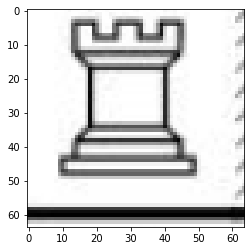

tensor([[-2.5191,  0.6552, -4.8572, -5.9523, -1.7961, -0.1648, -2.6413, -0.1350,
         -2.7724, -4.1801, -1.3648,  2.7252, -2.9624],
        [-2.2920, -0.5883,  1.7443,  4.7692, -3.4452, -1.2633, -3.6279, -5.6118,
         -3.9820, -3.2515, -4.1790, -3.7165, -0.7242],
        [-0.0991, -4.0163, -4.4127, -2.1978, -3.9566, -5.0062, -1.3227,  0.3167,
          1.9786,  4.2438, -5.5134, -4.2276,  0.1173],
        [-1.4467, -2.6261, -0.9662, -2.1454, -3.0378, -3.4744,  3.0552, -1.2867,
         -2.6540, -2.7194, -0.4917, -3.3877, -2.3488]],
       grad_fn=<AddmmBackward>) tensor([11,  3,  9,  6])
acc 1.0


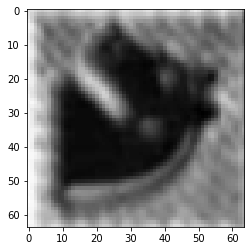

tensor([[-3.7244,  1.1761,  2.3471,  0.4916, -1.5994,  0.0757, -3.9167, -3.3575,
         -4.1947, -4.8414, -2.5116, -1.3943, -1.6089],
        [ 1.5676, -3.4155, -2.7914, -0.8337, -3.3902, -3.0528, -0.2288, -3.1703,
         -1.4493, -2.4041, -3.4374, -4.3231, -2.5799],
        [ 1.0944, -1.5231, -2.3274, -1.1337, -1.7861, -1.2763, -1.2066, -2.8698,
         -2.8731, -3.3784, -2.7846, -2.4464, -2.8431],
        [-2.7551, -3.1196, -4.8651, -3.7551, -4.6221, -5.7245, -0.3377,  0.9987,
          1.9611,  4.3552, -4.3889, -2.3813, -0.3650]],
       grad_fn=<AddmmBackward>) tensor([2, 0, 0, 9])
acc 1.0


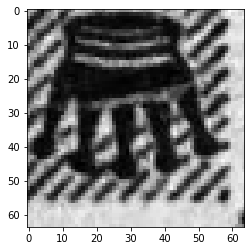

tensor([[-2.4429, -3.2684, -0.5824, -2.5206,  3.1677, -1.1998, -1.2677, -2.9885,
         -3.7750, -4.1637,  2.9430, -3.4764, -4.2774],
        [-1.3745,  0.1567, -1.5772, -0.0708, -1.6820,  3.1607, -3.8953, -3.8328,
         -4.8991, -5.8996, -4.4190, -3.9073, -4.9479],
        [ 0.5246, -0.4220, -1.4795,  0.2250, -4.8615, -4.2664, -0.5924, -2.3824,
         -0.7757,  1.4577, -4.6331, -2.2574,  4.6317],
        [-2.7896, -1.1912, -4.0449, -5.0643, -3.6959, -2.2695, -1.2865,  0.7092,
         -1.2356, -2.7944, -2.6969,  2.0799, -4.1962]],
       grad_fn=<AddmmBackward>) tensor([ 4,  5, 12, 11])
acc 1.0


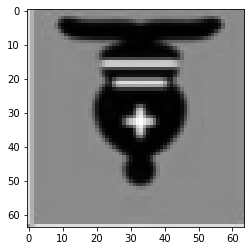

tensor([[ 2.2715, -3.2258, -2.4092, -1.2952, -2.2007, -2.8044, -1.9876, -0.5335,
         -1.3925, -1.1501, -4.4219, -4.8190, -3.0417],
        [-0.2263, -0.5451, -2.1975,  0.1174, -3.3712, -3.2760, -0.3512, -3.7953,
         -2.2338,  0.5467, -2.7149, -2.0587,  5.0038],
        [-5.1120, -3.6046, -2.9400, -3.7358, -2.3114, -1.5044, -0.0624, -0.7751,
         -1.2020, -2.9190, -0.4258,  1.5028, -5.1002],
        [-1.8023,  2.4953,  0.0448, -0.2711, -3.5791, -0.4701, -2.6976, -3.1374,
         -5.0766, -5.1183, -4.5467, -3.9981, -3.2937]],
       grad_fn=<AddmmBackward>) tensor([ 0, 12, 11,  1])
acc 1.0


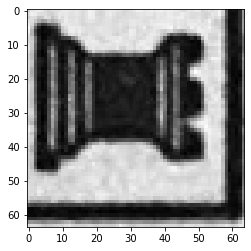

tensor([[-1.3659,  0.4788, -1.7381, -0.9232, -0.7035,  3.0556, -4.4578, -2.7040,
         -4.5546, -5.5554, -3.5837, -1.8925, -4.0403],
        [-2.6763, -0.4968, -2.2920, -2.2612, -1.3912, -1.5797, -3.2191, -2.2829,
         -2.8986, -2.7318, -1.2720,  1.5415, -0.9343],
        [-1.6083, -2.9451, -2.2946, -3.5480, -3.4960, -5.2507,  1.0472, -0.7971,
         -0.6347, -0.1449, -2.5500, -3.1675, -1.9856],
        [-1.5702, -3.5951, -2.2188, -1.6519, -4.7719, -5.4108,  2.2882, -1.4643,
          0.2665,  0.4720, -2.7358, -4.6672, -0.9009]],
       grad_fn=<AddmmBackward>) tensor([ 5, 11,  6,  6])
acc 1.0


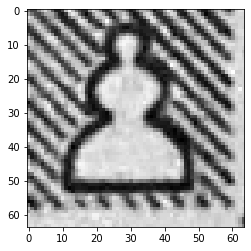

tensor([[-1.7820, -3.8366, -3.4024, -1.1825, -4.3590, -4.5235, -0.6369, -1.2664,
          1.4657,  3.3161, -3.7166, -1.8836,  1.0411],
        [-1.6822, -1.8720, -2.1247, -1.7847, -3.2574, -3.7205,  1.3439, -2.3366,
         -2.9456, -2.0822, -1.2266, -1.6530, -0.1357],
        [-1.3403, -2.4712, -3.9988, -5.9175, -2.7542, -3.7595, -1.3155,  3.4057,
          0.3123, -0.9771, -3.2991, -2.6109, -6.1149],
        [-1.1120,  1.3237,  0.0261,  1.5438, -1.5066,  2.3133, -4.4850, -5.7082,
         -4.8219, -6.1343, -3.9774, -2.4192, -2.7664]],
       grad_fn=<AddmmBackward>) tensor([9, 6, 7, 5])
acc 1.0


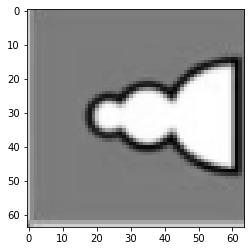

tensor([[-1.6358, -2.1316, -2.8293, -1.9841, -3.7595, -3.4612, -1.0130, -1.4141,
         -0.9833, -0.3129, -3.4960, -2.3426, -1.2263]],
       grad_fn=<AddmmBackward>) tensor([9])
acc 1.0

epoch: 0 avg loss train 0.07 acc 0.98 


In [93]:
for epoch in range(epochs):
    loss_epoch_train = []
    acc_epoch_train = []
    #loss_epoch_test = []
    count = 0
    model.train()
    for batch_inputs, batch_targets in tqdm(dataloader):
        #print(batch_inputs.shape)
#         if torch.cuda.is_available():
#             batch_inputs = batch_inputs.to("cuda")
#             batch_scores = batch_scores.to("cuda")
        
        plt.imshow(batch_inputs[0][0],cmap="gray")
        plt.show()
        
    
        batch_preds = model(batch_inputs)
        
        loss = loss_fun(batch_preds, batch_targets)
        print(batch_preds, batch_targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_epoch_train.append(loss.item())
        acc = get_accuracy(batch_preds, batch_targets).item()
        print("acc", acc)
        
        acc_epoch_train.append(acc)
    
    print("epoch: {} avg loss train {:.2f} acc {:.2f} ".format(epoch, np.mean(loss_epoch_train), np.mean(acc_epoch_train)))
        
#     model.eval()
#     for batch_inputs, batch_scores in tqdm(test_dataloader):
#         #print(batch_inputs.shape)
#         if torch.cuda.is_available():
#             batch_inputs = batch_inputs.to("cuda")
#             batch_scores = batch_scores.to("cuda")
        
#         pred_scores = model(batch_inputs).view(-1)
        
#         loss = torch.sum((pred_scores - batch_scores)**2)
        
#         loss_epoch_test.append(loss.item())
        
#   print("epoch: {} avg loss train {:.2f} avg loss test {:.2f} ".format(epoch, np.mean(loss_epoch_train), np.mean(loss_epoch_test)))

In [19]:
label2piece = {"0":"bB","1":"bK","2":"bN","3":"bP","4":"bQ","5":"bR","6":"wB","7":"wK","8":"wN","9":"wP","10":"wQ","11":"wR","12":"zbackground"}

In [231]:
random_index = np.random.randint(len(cd))

33
1
tensor([[-1.6235, -0.6013, -1.8786, -1.5998, -2.8014, -2.1373, -1.6223, -2.0034,
         -3.2144, -2.7208, -3.2563, -3.0530, -2.5480]],
       grad_fn=<AddmmBackward>)
bK


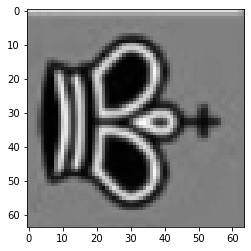

In [233]:
print(random_index)
plt.imshow(cd[random_index][0][0],cmap="gray")
print(cd[random_index][1])
output = model(cd[random_index][0].unsqueeze(0))
print(output)
print(label2piece[str(torch.argmax(output, dim=1).item())])